In [1]:
!pip3 install  transformers
!pip3 install torch
!pip3 install seaborn
!pip3 install tqdm
!pip3 install ipywidgets


     |████████████████████████████████| 1.3MB 19.4MB/s 
     |████████████████████████████████| 890kB 37.4MB/s 
     |████████████████████████████████| 2.9MB 38.2MB/s 
     |████████████████████████████████| 1.1MB 47.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=e1dc6433cf9b3adec7cae472df48d6021558e6b2fd1c96c1fe08dc2d97018b4a
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import transformers
import torch
import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import drive.MyDrive.lib.data_processing as lib
import importlib
from collections import defaultdict
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

importlib.reload(lib)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
TRAIN_FP = 'drive/MyDrive/bias_data/bias_data/WNC/biased.word.train'
TEST_FP = 'drive/MyDrive/bias_data/bias_data/WNC/biased.word.test'

In [5]:

wnc_train = lib.raw_data(TRAIN_FP, 3, 4)
wnc_train_df = wnc_train.add_miss_word_col(dtype='df')

wnc_test = lib.raw_data(TEST_FP, 3, 4)
wnc_test_df = wnc_test.add_miss_word_col(dtype='df')

In [6]:
wnc_test_df.head(5)

,0,1,2,3,4,5,6,7
0,235640083,the 51 day stand ##off and ensuing murder of 7...,the 51 day stand ##off and ensuing deaths of 7...,the 51 day standoff and ensuing murder of 76 m...,the 51 day standoff and ensuing deaths of 76 m...,DET NUM NOUN NOUN NOUN CCONJ VERB NOUN ADP NUM...,det nummod compound nsubj nsubj cc amod conj p...,"[murder, deaths]"
1,37561168,"mark o ##ate ##n ( born 8 march 1964 , watford...","mark o ##ate ##n ( born 8 march 1964 , watford...","mark oaten (born 8 march 1964, watford) is a d...","mark oaten (born 8 march 1964, watford) is a l...",NOUN ADJ ADJ ADJ PUNCT VERB NUM NOUN NUM PUNCT...,nsubj amod amod amod punct parataxis nummod np...,[disgraced]
2,101665256,another infamous period of colon ##isation in ...,another period of colon ##isation in ancient t...,another infamous period of colonisation in anc...,another period of colonisation in ancient time...,DET ADJ NOUN ADP NOUN NOUN ADP ADJ NOUN VERB A...,det amod nsubj prep pobj pobj prep amod pobj R...,[infamous]
3,480248865,photo sequence of astonishing 2005 chicago ##l...,photo sequence of 2005 chicago ##land crash wi...,photo sequence of astonishing 2005 chicagoland...,photo sequence of 2005 chicagoland crash with ...,NOUN NOUN ADP VERB NUM NOUN NOUN NOUN ADP ADJ ...,compound ROOT prep amod nummod compound compou...,[astonishing]
4,317239242,jesus of nazareth is probably mentioned in two...,jesus of nazareth is possibly mentioned in two...,jesus of nazareth is probably mentioned in two...,jesus of nazareth is possibly mentioned in two...,PROPN ADP ADJ VERB ADV VERB ADP NUM NOUN ADP D...,nsubjpass prep pobj auxpass advmod ROOT prep n...,"[probably, possibly]"


In [7]:
sample = lib.raw_data('drive/MyDrive/bias_data/bias_data/real_world_samples/ibc_right', 2, 3)
sample.add_miss_word_col(dtype='df').head(5)

,0,1,2,3,4,5,6,7
0,b057ee3e-ef62-4126-a681-dd4a86b25a15,"when told of thompson ' s appointment , nixon ...","when told of thompson ' s appointment , nixon ...","when told of thompson 's appointment , nixon r...","when told of thompson 's appointment , nixon r...",ADV VERB ADP NOUN PUNCT VERB NOUN PUNCT NOUN V...,advmod advcl prep nmod punct compound pobj pun...,"[', s, `, `, ', ', `, `, 's, ``, '', ``]"
1,9c8e1855-c9d0-45d1-b1c6-a8e8a5eb7f61,some parents might argue that placing their ch...,some parents might argue that placing their ch...,some parents might argue that placing their ch...,some parents might argue that placing their ch...,DET NOUN VERB VERB ADP VERB ADJ NOUN ADP NOUN ...,det nsubj aux ROOT mark csubj poss dobj prep c...,"[re, ##ap, ##ing, tax, ##ed, reaping, taxed]"
2,a0f170e2-0c0c-49ca-9b53-9d758bf295b8,beneath this bland good obama lies a more inte...,beneath this bland good obama lies a more inte...,beneath this bland good obama lies a more inte...,beneath this bland good obama lies a more inte...,ADP DET ADJ ADJ NOUN VERB DET ADV ADJ NOUN PUN...,prep det amod amod pobj ROOT det advmod amod n...,"[better, -, the, ', s, self, -, pity, un, ##fu..."
3,5313376a-876f-4af7-9a33-52c964e48898,"worse yet , it s ##neer ##ingly de ##pre ##cat...","worse yet , it s ##neer ##ingly de ##pre ##cat...","worse yet , it sneeringly deprecates the genui...","worse yet , it sneeringly deprecates the genui...",ADV ADV PUNCT PRON ADV ADV ADV VERB VERB VERB ...,advmod advmod punct nsubj advmod advmod advmod...,"[s, ##neer, ##ingly, de, ##pre, ##cate, ##s, a..."
4,9beb9114-f3b9-4788-ae7e-c03634593860,and obama ' s pick to head the department of a...,and obama ' s pick to head the department of a...,and obama 's pick to head the department of ag...,and obama 's pick to head the department of ag...,CCONJ NOUN PUNCT VERB VERB PART VERB DET NOUN ...,cc nsubj punct nsubj nsubj aux xcomp det dobj ...,"[', s, vi, ##ls, ##ack, manipulation, ##s, 's,..."


In [40]:
train_df = wnc_train.make_training_array(wnc_train_df)
test_df = wnc_test.make_training_array(wnc_test_df)

print(train_df.head())
print(test_df.head())

                                              string  label
0  established just after the first world war, du...      0
1  during the second sino-japanese war (which too...      1
2  in january 2014, the christian democratic move...      0
3  gustav liked to compare himself to moses, whom...      0
4  jean duthie beggs cbe frs (born 16 april 1950)...      1
                                              string  label
0   two distinct views exist on the meaning of time.      0
1  south korea currently physically occupies the ...      1
2  in 2004, ace became the sole mascot of the tea...      1
3                   jaime moyer, actress/ comedienne      1
4  he auditioned for idol in seattle, washington ...      1


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0, 'Unbiased'), Text(0, 0, 'Biased')]

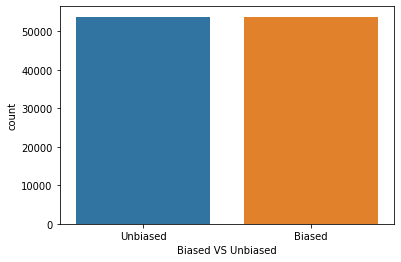

In [44]:
class_names = ["Unbiased", "Biased"]
ax = sns.countplot(train_df.label)
plt.xlabel('Biased VS Unbiased')
ax.set_xticklabels(class_names)


In [10]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'


In [11]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [45]:
# some testing
sample_txt = 'Finals Week!!'


In [46]:
sample_encoded_token = tokenizer.encode_plus(sample_txt,max_length=150, padding='max_length', add_special_tokens=True, return_token_type_ids=False, return_attention_mask=True, return_tensors='pt')

In [47]:
print(sample_encoded_token["input_ids"].flatten())
print(sample_encoded_token["attention_mask"].flatten())

tensor([ 101, 9801, 6237,  106,  106,  102,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,   

In [15]:
## most strings are less than 150 tokens

MAX_LEN = 150

In [64]:
class WNCDataset(Dataset):
    def __init__(self, sentences, targets, tokenizer, max_len):
        self.sentences = sentences
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.sentences)
    def __getitem__(self, item):
        sentence = str(self.sentences[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
          sentence,
          add_special_tokens=True,
          max_length=self.max_len,
          truncation=True,
          return_token_type_ids=False,
          padding='max_length',
          return_attention_mask=True,
          return_tensors='pt',
        )

        return {
          'sentence': sentence,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'targets': torch.tensor(target, dtype=torch.long)
        }
    

In [65]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = WNCDataset(
    sentences=df.string.to_numpy(),
    targets=df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len,
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [77]:
BATCH_SIZE = 8

train_data_loader = create_data_loader(train_df[0:1000], tokenizer, MAX_LEN, BATCH_SIZE)
# val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test_df, tokenizer, MAX_LEN, BATCH_SIZE)

In [78]:
data = next(iter(train_data_loader))
data.keys() 

dict_keys(['sentence', 'input_ids', 'attention_mask', 'targets'])

In [79]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([8, 150])
torch.Size([8, 150])
torch.Size([8])


In [80]:
class BiasClassifier(nn.Module):

  def __init__(self, n_classes):
    super(BiasClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)



In [81]:
model = BiasClassifier(len(class_names))
model = model.to(device)


In [23]:
## TRAINING

In [94]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [95]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer,
  device,
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [90]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer,
    device,
    scheduler, 
    1000
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  test_acc, test_loss = eval_model(
    model,
    test_data_loader,
    loss_fn,
    device, 
    len(test_df)
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)


Epoch 1/10
----------
Train loss 0.5587489280644804 accuracy 0.793
Val   loss 1.4978924241662026 accuracy 0.6211211211211212

Epoch 2/10
----------
Train loss 0.2885916327293962 accuracy 0.922


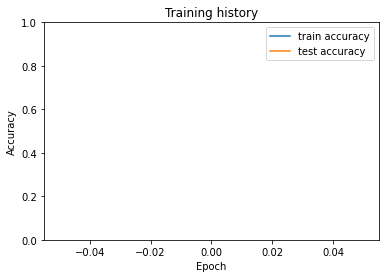

In [93]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='test accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [31]:
print(history["train_acc"])
print(history["test_acc"])

[tensor(2.7880e-05, device='cuda:0', dtype=torch.float64), tensor(8.3640e-05, device='cuda:0', dtype=torch.float64), tensor(7.4347e-05, device='cuda:0', dtype=torch.float64), tensor(7.4347e-05, device='cuda:0', dtype=torch.float64), tensor(7.4347e-05, device='cuda:0', dtype=torch.float64), tensor(8.3640e-05, device='cuda:0', dtype=torch.float64), tensor(9.2933e-05, device='cuda:0', dtype=torch.float64), tensor(9.2933e-05, device='cuda:0', dtype=torch.float64), tensor(9.2933e-05, device='cuda:0', dtype=torch.float64), tensor(9.2933e-05, device='cuda:0', dtype=torch.float64)]
[tensor(0.4995, device='cuda:0', dtype=torch.float64), tensor(0.5000, device='cuda:0', dtype=torch.float64), tensor(0.5000, device='cuda:0', dtype=torch.float64), tensor(0.5000, device='cuda:0', dtype=torch.float64), tensor(0.5005, device='cuda:0', dtype=torch.float64), tensor(0.5000, device='cuda:0', dtype=torch.float64), tensor(0.5000, device='cuda:0', dtype=torch.float64), tensor(0.5000, device='cuda:0', dtype=to